In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyIEEM.data.utils import to_pd_interval

In [6]:
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

def smooth_matrix(matrix, df, degree):
    """
    A function to GAM smooth contact matrices
    
    Input
    -----
    
    matrix: pd.Series
        Index: age_x, age_y. Name: predicted_contacts. Unsmoothed matrix.

    df: int
        Number of B-splines for GAM fit
        
    degree: int
        Degree of B-splines for GAM fit    
    
    Output
    ------
    
    matrix: pd.Series
        Index: age_x, age_y. Name: predicted_contacts. Smoothed matrix.
    """
    
    # drop index
    matrix = matrix.reset_index()

    # replace categoral with midpoint of interval (in case data are not equidistant)
    age_classes = matrix['age_x'].unique()
    
    for var in ['age_x', 'age_y']:
        for i,age_class in zip(range(len(age_classes)), age_classes):
            matrix.loc[matrix.index[matrix[var] == age_class], var] = age_classes[i].mid  
    matrix = matrix.astype(float)

    # fit GAM
    x_spline = matrix[['age_x', 'age_y']]
    bs = BSplines(x_spline, df=[df,df], degree=[degree, degree])
    model = GLMGam.from_formula('contacts ~ age_x + age_y + age_x*age_y', data=matrix, smoother=bs,
                                family=sm.families.NegativeBinomial(), alpha=np.array([0.1, 0.1]), method='newton')

    # fit GAM model
    res = model.fit()
    
    # predict matrix of contacts
    smoothed_values = res.predict()
    
    # merge back into dataframe
    matrix['smoothed_contacts'] = smoothed_values
    
    # set multiindex
    matrix = matrix.groupby(by=['age_x','age_y']).last()

    # re-introduce the age classes as index
    matrix.index = matrix.index.set_levels(age_classes, level=0)
    matrix.index = matrix.index.set_levels(age_classes, level=1)

    return matrix.squeeze()

In [ ]:
# Function to integrate contact matrix



In [7]:
data = pd.read_csv('comesf_matrices.csv', index_col = [0,1,2,3,4,5,6], converters = {'age_x': to_pd_interval, 'age_y': to_pd_interval})
age_classes = list(data.index.get_level_values('age_x').unique().sort_values().values)
data = data.rename(columns={'desired_format': 'contacts'})

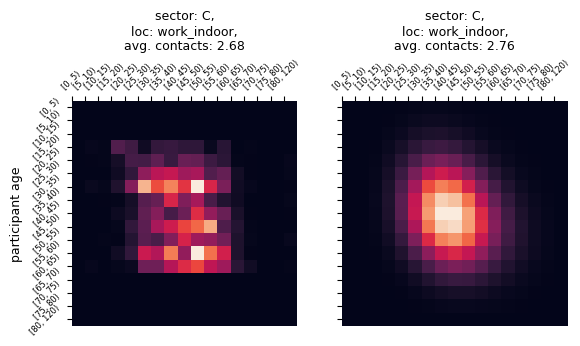

In [8]:
# visualize result
location = 'work_indoor'
sector = 'C'
vacation = False

# slice data
sl = data.groupby(by=['location', 'sector', 'type_day', 'vacation', 'age_x', 'age_y']).sum()

# compute average week/weekend
week = sl.loc[location, sector, 'weekday', vacation]#
weekend = sl.loc[location, sector, 'weekendday', vacation]#.values.reshape(2*[len(age_classes),])
mat = 2/7*weekend + 5/7*week
mat_smooth = smooth_matrix(mat, 4, 3)['smoothed_contacts'].values.reshape(2*[len(age_classes),])
mat = (2/7*weekend + 5/7*week).values.reshape(2*[len(age_classes),])

#duration_min = [37.5, 10, 150, 2.5, 240]
#for i,dur in enumerate(data.index.get_level_values('duration').unique()):
#    week += duration_min[i]*data.groupby(by=['location', 'duration', 'type_day', 'sector',  'vacation', 'age_x', 'age_y']).sum().loc[location, dur, 'weekday', sector, False, slice(None), slice(None)].values.reshape(2*[len(age_classes),])
# age_x*sector + age_y*sector    weekend += duration_min[i]*data.groupby(by=['location', 'duration', 'type_day', 'sector',  'vacation', 'age_x', 'age_y']).sum().loc[location, dur, 'weekendday', sector, False, slice(None), slice(None)].values.reshape(2*[len(age_classes),])
#m = 2/7*weekend + 5/7*week

# visualise result
fig,axs=plt.subplots(nrows=1, ncols=2, sharey=True)
for i, m in enumerate([mat, mat_smooth]):
    ax = axs[i]
    ax = sns.heatmap(m, annot=False, fmt='.1f', ax=ax, square=True, cbar=False, annot_kws={"size":6})
    ax.xaxis.tick_top() # x axis on top
    ax.xaxis.set_label_position('top')
    ax.set_xticks(range(len(age_classes)))
    ax.set_xticklabels(age_classes, rotation = 45, size=6)
    ax.set_yticklabels(age_classes, rotation = 45, size=6)
    ax.set_title(f'sector: {sector},\nloc: {location},\navg. contacts: {np.mean(np.sum(m,axis=1)):.2f}', fontsize=9)

axs[0].set_ylabel('participant age', fontsize=9)
plt.show()
plt.close()